In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/database/captcha-samples-wordpress.zip ./

In [ ]:
!unzip captcha-samples-wordpress.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/JXCB.png          
  inflating: train/JUZH.png          
  inflating: train/JXVK.png          
  inflating: train/JXJX.png          
  inflating: train/JWZD.png          
  inflating: train/JVFF.png          
  inflating: train/JX8K.png          
  inflating: train/JXPP.png          
  inflating: train/JWAH.png          
  inflating: train/JXP3.png          
  inflating: train/JX2C.png          
  inflating: train/JW47.png          
  inflating: train/JVHG.png          
  inflating: train/JV52.png          
  inflating: train/JV5X.png          
  inflating: train/JX42.png          
  inflating: train/JVM5.png          
  inflating: train/JXLS.png          
  inflating: train/JVW6.png          
  inflating: train/JTW3.png          
  inflating: train/JUY4.png          
  inflating: train/JVAY.png          
  inflating: train/JW65.png          
  inflating: train/JWNV.png          
  inflating: train/JWD5.png          

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
from keras.datasets import mnist
import cv2
from glob import glob
import os
from keras.models import load_model
from keras.utils import plot_model
from keras.layers import concatenate
from keras.models import Model

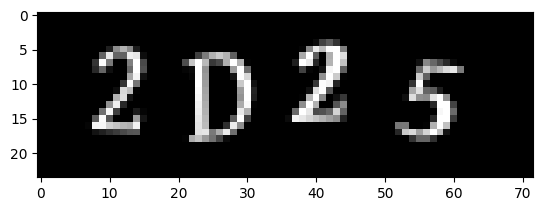

In [ ]:
im=cv2.imread('train/2D25.png')
im=(255-cv2.cvtColor(im,cv2.COLOR_BGR2GRAY))/255.0
plt.imshow(im,'gray')

In [ ]:
def load_data(p):
  pattern=os.path.join(p,'*.png')
  files=glob(pattern)
  targets=[]
  images=[]

  for file in files:
    char=list(os.path.splitext(os.path.basename(file))[0])
    if len(char)!=4:
      continue
    targets.append(char)
    im=cv2.imread(file)
    im=(255-cv2.cvtColor(im,cv2.COLOR_BGR2GRAY))/255.0
    images.append(im)

  targets=np.array(targets)
  images=np.array(images)

  return images,targets





In [ ]:
x,y=load_data('train/')
x_test,y_test=load_data('test/')
print(x.shape,y.shape)
print(x_test.shape,y_test.shape)

(9843, 24, 72) (9843, 4)
(100, 24, 72) (100, 4)


In [ ]:
encoder=LabelEncoder()
Y_encoded=encoder.fit(y.reshape(-1))
with open('encoder.bin','wb')as f:
  pickle.dump(encoder,f)


In [ ]:
Y_encoded=encoder.transform(y.reshape(-1)).reshape(-1,4)
Y_encoded_test=encoder.transform(y_test.reshape(-1)).reshape(-1,4)
Y_encoded_test.shape

(100, 4)

In [ ]:
def build_model(num_classes=32):
  input_layer=Input(shape=(24, 72, 1),name='input')
  x1 = Conv2D(4, (3,3), padding='same', activation='relu')(input_layer)
  x1 = Conv2D(8, (3,3), padding='same', activation='relu')(x1)
  x1 = Conv2D(16, (3,3), padding='same', activation='relu')(x1)
  Flatten_1=Flatten()(x1)


  x2 = Conv2D(4, (3,3), padding='same', activation='relu')(input_layer)
  x2 = Conv2D(8, (3,3), padding='same', activation='relu')(x2)
  x2 = Conv2D(16, (3,3), padding='same', activation='relu')(x2)
  Flatten_2=Flatten()(x2)


  x3 = Conv2D(4, (3,3), padding='same', activation='relu')(input_layer)
  x3 = Conv2D(8, (3,3), padding='same', activation='relu')(x3)
  x3 = Conv2D(16, (3,3), padding='same', activation='relu')(x3)
  Flatten_3=Flatten()(x3)


  x4 = Conv2D(4, (3,3), padding='same', activation='relu')(input_layer)
  x4 = Conv2D(8, (3,3), padding='same', activation='relu')(x4)
  x4 = Conv2D(16, (3,3), padding='same', activation='relu')(x4)
  Flatten_4=Flatten()(x4)

  merge=concatenate([Flatten_1,Flatten_2,Flatten_3,Flatten_4],name='concatenate')

  h=Dense(512,activation='relu',name='dense_512')(merge)
  h=Dense(128,activation='relu',name='dense_128')(h)

  h1=Dense(128,activation='relu',name='dense_out1')(h)
  out1=Dense(num_classes,activation='softmax',name='out1')(h1)

  h2=Dense(128,activation='relu',name='dense_out2')(h)
  out2=Dense(num_classes,activation='softmax',name='out2')(h2)

  h3=Dense(128,activation='relu',name='dense_out3')(h)
  out3=Dense(num_classes,activation='softmax',name='out3')(h3)

  h4=Dense(128,activation='relu',name='dense_out4')(h)
  out4=Dense(num_classes,activation='softmax',name='out4')(h)

  model=Model(inputs=input_layer,outputs=[out1,out2,out3,out4])
  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy']
                 )
  return model




In [ ]:
def fit_image(X,Y,XT,YT,num_classes=32):
  yt=[to_categorical(Y[:,i],num_classes=num_classes)for i in range(4)]
  yt_test=[to_categorical(YT[:,i],num_classes=num_classes) for i in range(4)]
  model=build_model(num_classes=32)
  H=model.fit(X,yt,validation_data=(XT,yt_test),epochs=30,verbose=1)
  train_acc = model.evaluate(X, yt)
  test_acc = model.evaluate(XT, yt_test)
  return model,train_acc,test_acc


In [ ]:
models=[]
model,train_acc,test_acc=fit_image(x,Y_encoded,x_test,Y_encoded_test)
models.append(model)

Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - loss: 12.2816 - out1_accuracy: 0.1168 - out1_loss: 3.1565 - out2_accuracy: 0.1361 - out2_loss: 3.0742 - out3_accuracy: 0.1295 - out3_loss: 3.1101 - out4_accuracy: 0.1884 - out4_loss: 2.9408 - val_loss: 3.8033 - val_out1_accuracy: 0.7200 - val_out1_loss: 1.0027 - val_out2_accuracy: 0.6700 - val_out2_loss: 0.9207 - val_out3_accuracy: 0.6300 - val_out3_loss: 0.9942 - val_out4_accuracy: 0.7600 - val_out4_loss: 1.0246
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 2.3483 - out1_accuracy: 0.7853 - out1_loss: 0.6313 - out2_accuracy: 0.8004 - out2_loss: 0.5856 - out3_accuracy: 0.7835 - out3_loss: 0.6370 - out4_accuracy: 0.8366 - out4_loss: 0.4944 - val_loss: 1.1290 - val_out1_accuracy: 0.9400 - val_out1_loss: 0.1282 - val_out2_accuracy: 0.8900 - val_out2_loss: 0.2645 - val_out3_accuracy: 0.9100 - val_out3_loss: 0.2164 - val_out4_accuracy: 0.8700 - val_out4_loss: 0.3096
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - l

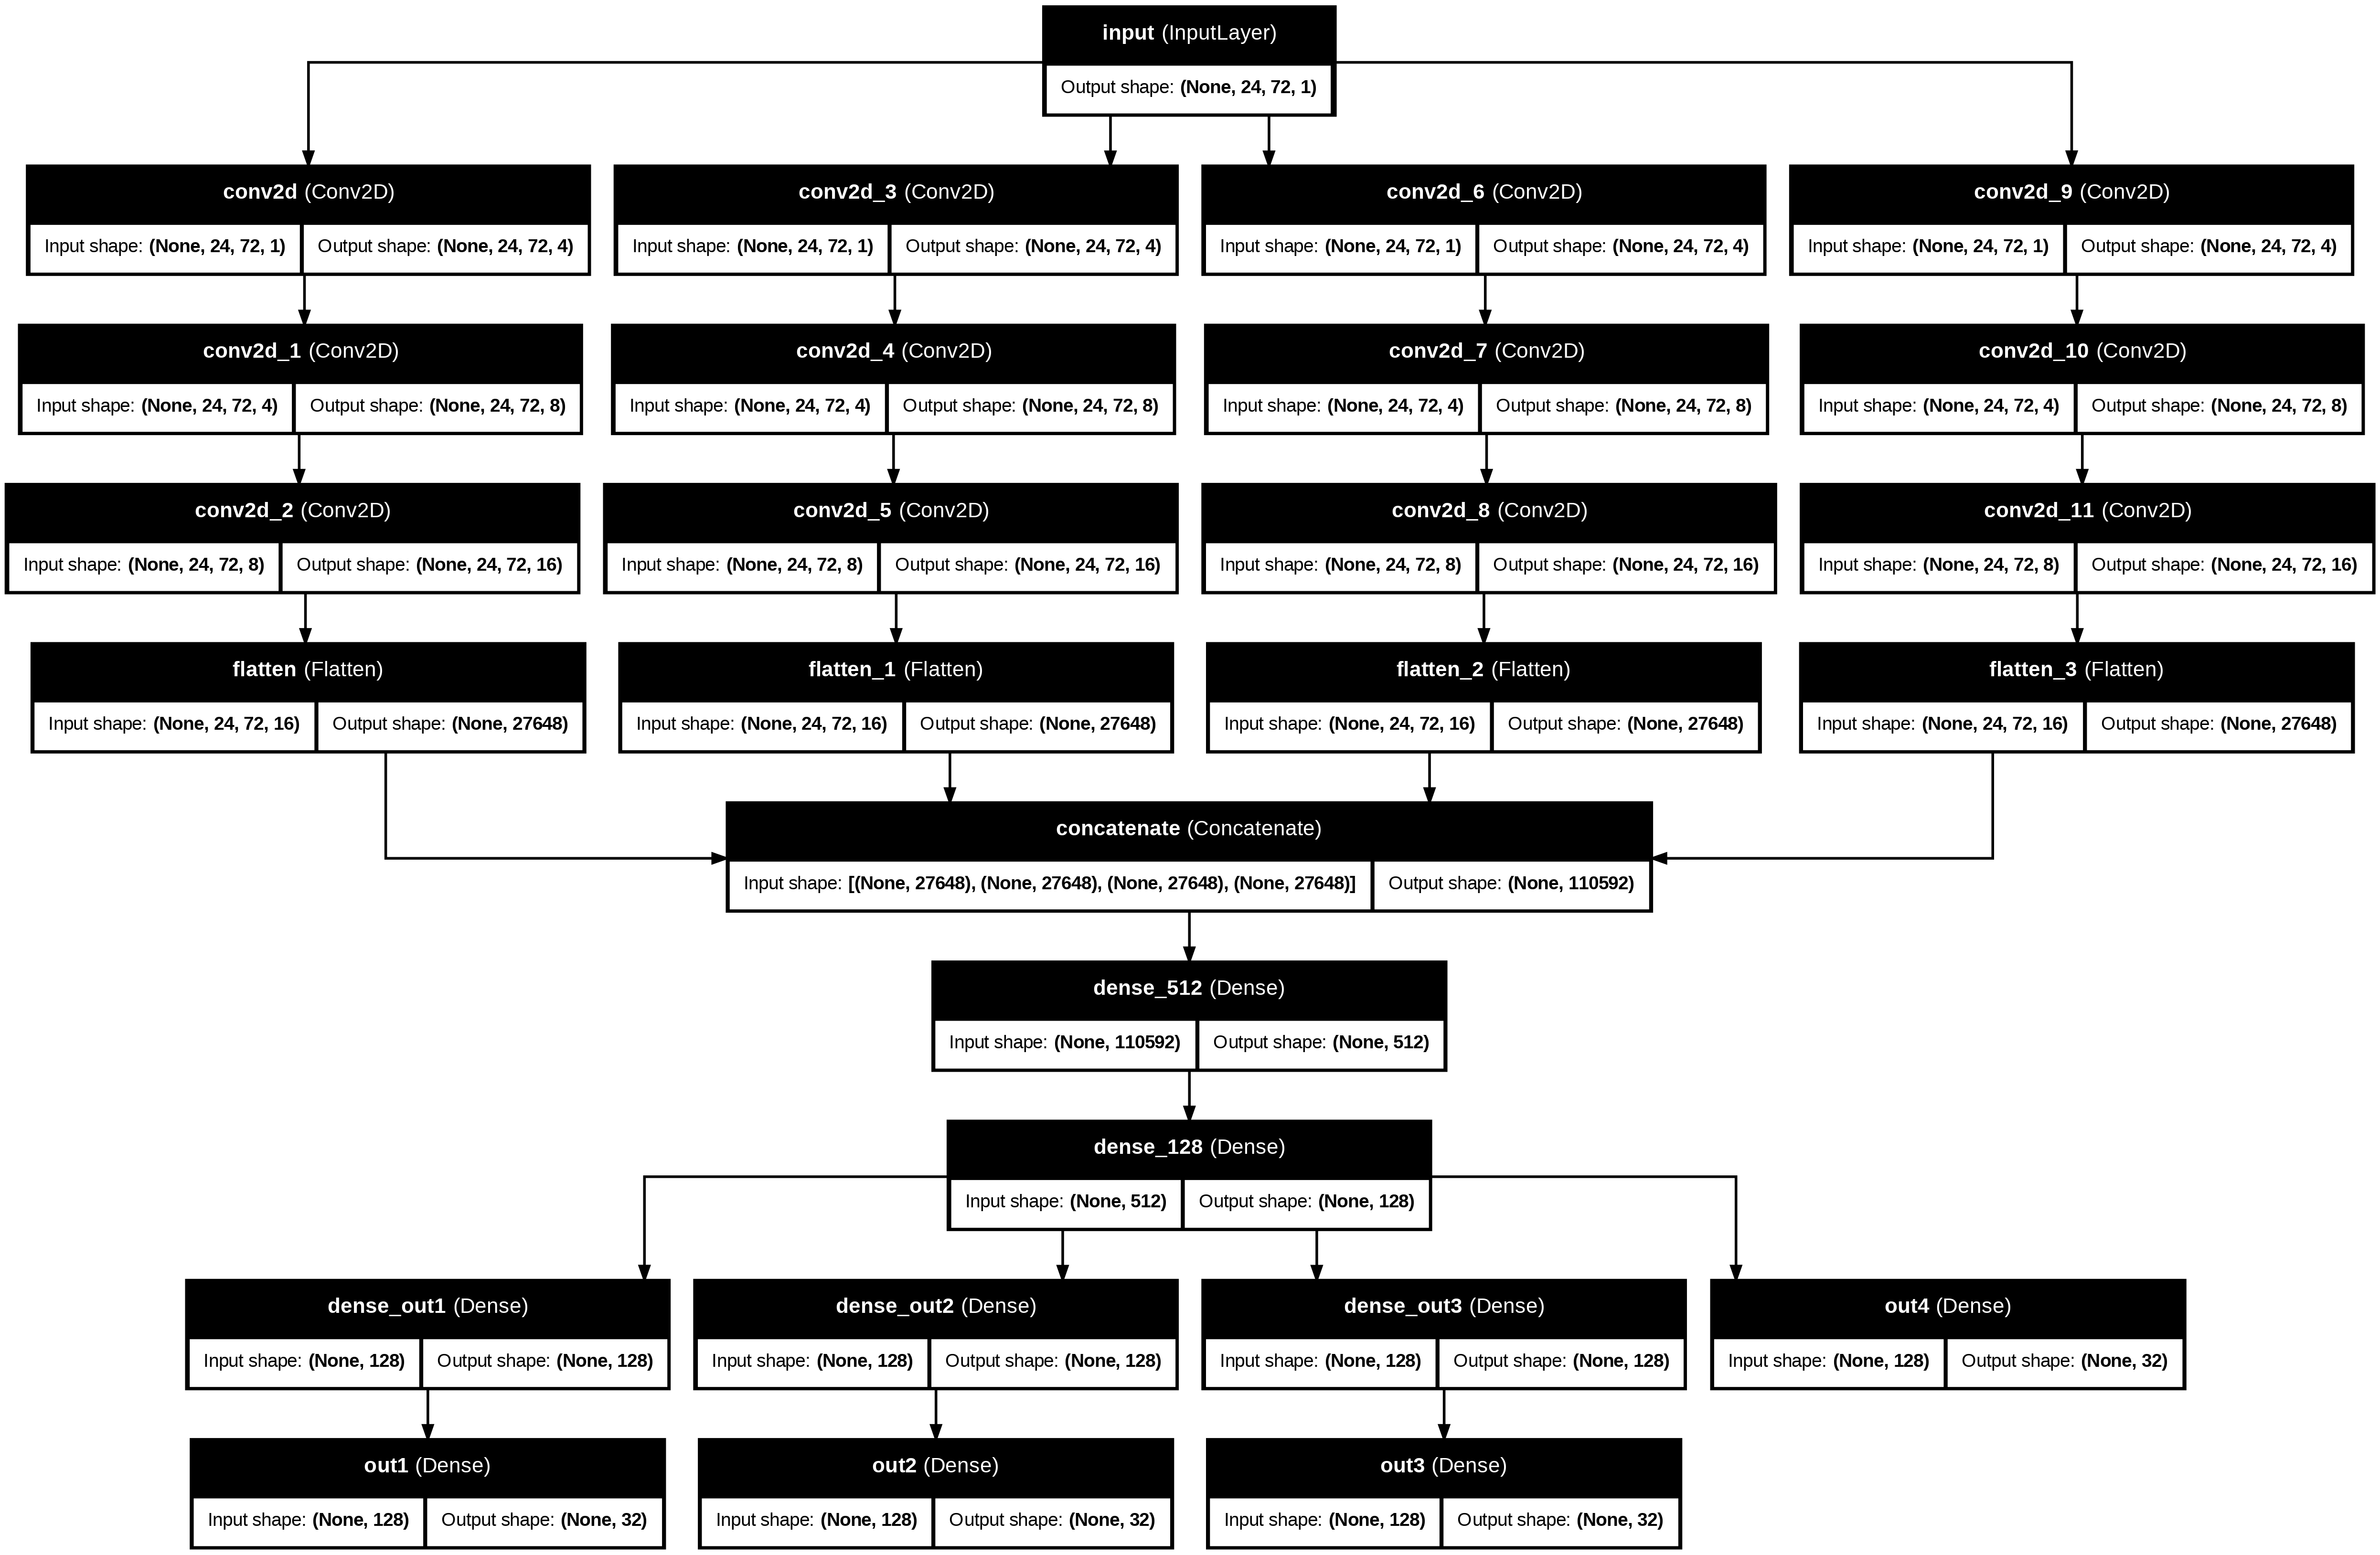

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.save('captcha_model.keras')

In [ ]:
def predict(x):
    # Load encoder
    with open('encoder.bin','rb') as f:
        encoder = pickle.load(f)

    # Load مدل
    model = load_model('captcha_model.keras')

    # آماده‌سازی ورودی
    x_input = x.reshape(1, 24, 72, 1)

    preds = model.predict(x_input)
    chars = []
    for p in preds:
        p_class = np.argmax(p)
        p_label = encoder.inverse_transform([p_class])[0]
        chars.append(p_label)
    return ''.join(chars)



In [ ]:
def predict_img(path):

    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = (255 - im) / 255.0
    return predict(im)

In [ ]:
f = 'test/CFCG.png'
out = predict_img(f)
out

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


'CFCG'